# Overview

In this project, I will use Neural Network Matrix Factorization with Keras to predict the ratings for the movies in [MovieLens Small Datasets](https://grouplens.org/datasets/movielens/latest/)


## [Recommender system](https://en.wikipedia.org/wiki/Recommender_system)
A recommendation system is basically an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. It is widely used in different internet / online business such as Amazon, Netflix, Spotify, or social media like Facebook and Youtube. By using recommender systems, those companies are able to provide better or more suited products/services/contents that are personalized to a user based on his/her historical consumer behaviors


## [Neural Collaborative Filtering](https://dl.acm.org/citation.cfm?id=3052569)
DMF is an architecture of deep neural network to project users and items into a latent structured space. In this architecture, there are two multi-layer networks to transform the representations of u and v respectively. Through the neural network, the user ui and item vj are finally mapped to a low-dimensional vector in a latent space. Then the dot product of user ui and item vj at low-dimensional space is the prediction of rating for that user i and item j. I will use Squared loss as our objective function to train the DMF


## Data Sets
We use [MovieLens Small Datasets](https://grouplens.org/datasets/movielens/latest/)
This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100004 ratings and 1296 tag applications across 9125 movies. These data were created by 671 users between January 09, 1995 and October 16, 2016. This dataset was generated on October 17, 2016.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`


## Project Content
1. Load Data
2. Split Data Into Train/Test
3. Train Generalized Matrix Factorization Model and Test Model
4. Train Multi-Layer Perceptron Model and Test Model
5. Train Neural Matrix Factorization (NeuMF) and Test Model

In [2]:
import os

# data science imports
import numpy as np
import pandas as pd

# sklearn imports
from sklearn.model_selection import train_test_split

# keras/tensorflow imports
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

# visualization imports
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# path config
os.environ['DATA_PATH'] = '../data/'
data_path = os.path.join(os.environ['DATA_PATH'], 'movie')

## 1. Load Data

In [4]:
df_ratings = pd.read_csv(
    os.path.join(data_path, 'ratings.csv'),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [5]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
userId     100004 non-null int32
movieId    100004 non-null int32
rating     100004 non-null float32
dtypes: float32(1), int32(2)
memory usage: 1.1 MB


In [6]:
df_ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [7]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 671 unique users and 9066 unique movies in this data set


In [8]:
user_maxId = df_ratings.userId.max()
item_maxId = df_ratings.movieId.max()
print('There are {} distinct users and the max of user ID is also {}'.format(num_users, user_maxId))
print('There are {} distinct movies, however, the max of movie ID is {}'.format(num_items, item_maxId))
print('In the context of matrix factorization, the current item vector is in unnecessarily high dimensional space')
print('So we need to do some data cleaning to reduce the dimension of item vector back to {}'.format(num_items))

There are 671 distinct users and the max of user ID is also 671
There are 9066 distinct movies, however, the max of movie ID is 163949
In the context of matrix factorization, the current item vector is in unnecessarily high dimensional space
So we need to do some data cleaning to reduce the dimension of item vector back to 9066


In [9]:
def reduce_item_dim(df_ratings):
    """
    Reduce item vector dimension to the number of distinct items in our data sets
    
    input: pd.DataFrame, df_ratings should have columns ['userId', 'movieId', 'rating']
    output: pd.DataFrame, df_ratings with new 'MovieID' that is compressed
    """
    # pivot
    df_user_item = df_ratings.pivot(index='userId', columns='movieId', values='rating')
    # reset movieId
    df_user_item = df_user_item.T.reset_index(drop=True).T
    # undo pivot/melt - compress data frame
    df_ratings_new = df_user_item \
        .reset_index('userId') \
        .melt(
            id_vars='userId', 
            value_vars=df_user_item.columns,
            var_name='movieId',
            value_name='rating')
    # drop nan and final clean up
    return df_ratings_new.dropna().sort_values(['userId', 'movieId']).reset_index(drop=True)

In [10]:
print('reduce item dimension before:')
df_ratings.head()

reduce item dimension before:


,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [11]:
df_ratings = reduce_item_dim(df_ratings)
print('reduce item dimension after:')
df_ratings.head()

reduce item dimension after:


,userId,movieId,rating
0,1,30,2.5
1,1,833,3.0
2,1,859,3.0
3,1,906,2.0
4,1,931,4.0


## 2. Split Data Into Train/Test

In [12]:
df_train, df_test = train_test_split(df_ratings, test_size=0.2, shuffle=True, random_state=99)
print('shape of training data set:')
print(df_train.shape)
print('shape of test data set:')
print(df_test.shape)

shape of training data set:
(80003, 3)
shape of test data set:
(20001, 3)


## 3. Train Generalized Matrix Factorization and Test Model

### define GMF model architeture and train routine

In [13]:
def get_GMF_model(num_users, num_items, latent_dim, vu_reg, vi_reg):
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    latent_dim: int, embedded dimension for user vector and item vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(vu_reg),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(vi_reg),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model


def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
    # compile model
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath=os.path.join(data_path, 'tmp/model.hdf5'),
                                  monitor='val_rmse',
                                  save_best_only=True,
                                  save_weights_only=True)
    # train model
    history = model.fit(inputs, outputs,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_split,
                        callbacks=[early_stopper, model_saver])
    return history


def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

### create GMF model

In [14]:
GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0)
GMF_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        6720        user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        90670       item_input[0][0]                 
__________________________________________________________________________________________________
flatten (F

### train GMF model

In [15]:
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(GMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

/Users/Kevin/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 60002 samples, validate on 20001 samples
Epoch 1/30
60002/60002 [==============================] - 2s 39us/step - loss: 7.2856 - mean_squared_error: 7.2856 - rmse: 2.5509 - val_loss: 1.8228 - val_mean_squared_error: 1.8228 - val_rmse: 1.3466
Epoch 2/30
60002/60002 [==============================] - 2s 31us/step - loss: 1.2941 - mean_squared_error: 1.2941 - rmse: 1.1303 - val_loss: 1.0716 - val_mean_squared_error: 1.0716 - val_rmse: 1.0314
Epoch 3/30
60002/60002 [==============================] - 2s 32us/step - loss: 0.9364 - mean_squared_error: 0.9364 - rmse: 0.9632 - val_loss: 0.9376 - val_mean_squared_error: 0.9376 - val_rmse: 0.9641
Epoch 4/30
60002/60002 [==============================] - 2s 32us/step - loss: 0.8231 - mean_squared_error: 0.8231 - rmse: 0.9029 - val_loss: 0.8891 - val_mean_squared_error: 0.8891 - val_rmse: 0.9384
Epoch 5/30
60002/60002 [==============================] - 2s 36us/step - loss: 0.7656 - mean_squared_error: 0.7656 - rmse: 0.8704 - val_loss: 0.86

### GMF learning curve

In [16]:
def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

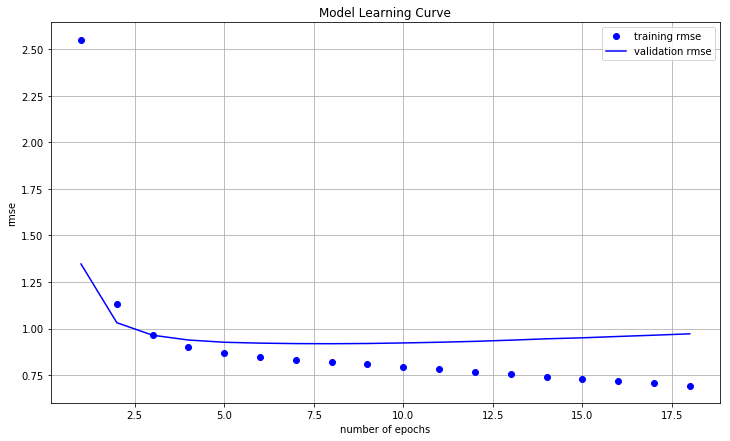

In [17]:
plot_learning_curve(history, 'rmse')

### GMF model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [18]:
# define rmse function
rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions) - np.squeeze(df_test.rating.values))))

In [19]:
# load best model
GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0)
GMF_model = load_trained_model(GMF_model, os.path.join(data_path, 'tmp/model.hdf5'))
# make prediction using test data
predictions = GMF_model.predict([df_test.userId.values, df_test.movieId.values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.9237


## 4. Train Multi-Layer Perceptron Model and Test Model

### define MLP model architeture

In [21]:
def get_MLP_model(num_users, num_items, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

### create MLP model

In [22]:
MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 32)        21504       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 32)        290144      item_input[0][0]                 
__________________________________________________________________________________________________
flatten_4 

### train MLP model

In [23]:
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(MLP_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

/Users/Kevin/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 60002 samples, validate on 20001 samples
Epoch 1/30
60002/60002 [==============================] - 6s 105us/step - loss: 1.1327 - mean_squared_error: 1.1327 - rmse: 1.0321 - val_loss: 0.8792 - val_mean_squared_error: 0.8792 - val_rmse: 0.9327
Epoch 2/30
60002/60002 [==============================] - 4s 74us/step - loss: 0.8239 - mean_squared_error: 0.8239 - rmse: 0.9028 - val_loss: 0.8250 - val_mean_squared_error: 0.8250 - val_rmse: 0.9032
Epoch 3/30
60002/60002 [==============================] - 5s 77us/step - loss: 0.7563 - mean_squared_error: 0.7563 - rmse: 0.8648 - val_loss: 0.8108 - val_mean_squared_error: 0.8108 - val_rmse: 0.8958
Epoch 4/30
60002/60002 [==============================] - 4s 69us/step - loss: 0.7155 - mean_squared_error: 0.7155 - rmse: 0.8413 - val_loss: 0.8267 - val_mean_squared_error: 0.8267 - val_rmse: 0.9037
Epoch 5/30
60002/60002 [==============================] - 4s 68us/step - loss: 0.6923 - mean_squared_error: 0.6923 - rmse: 0.8268 - val_loss: 0.8

### MLP learning curve

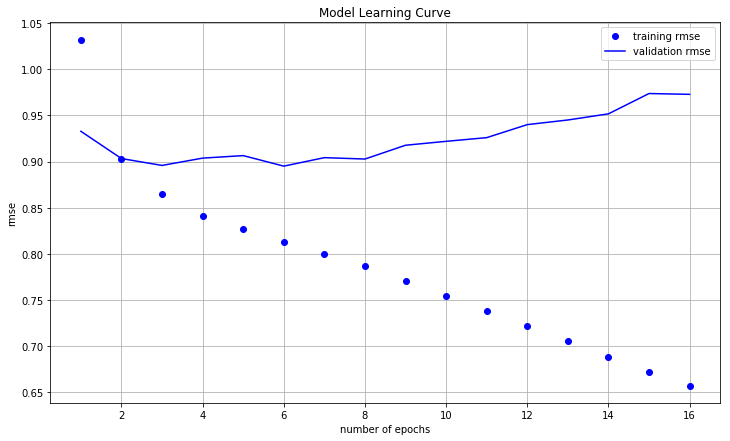

In [24]:
plot_learning_curve(history, 'rmse')

### MLP model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [25]:
# load best model
MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model = load_trained_model(MLP_model, os.path.join(data_path, 'tmp/model.hdf5'))
# make prediction using test data
predictions = MLP_model.predict([df_test.userId.values, df_test.movieId.values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.9094


## 5. Train Neural Matrix Factorization (NeuMF) and Test Model

### define NeuMF model architeture

In [34]:
def get_NeuMF_model(num_users, num_items, MF_dim, MF_reg, MLP_layers, MLP_regs):
    """
    Build Neural Matrix Factorization (NeuMF) Model Topology.
    This is stack version of both GMF and MLP
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    MF_dim: int, embedded dimension for user vector and item vector in MF
    MF_reg: tuple of float, L2 regularization of MF embedded layer
    MLP_layers: list of int, each element is the number of hidden units for each MLP layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    MLP_regs: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # Embedding layer
    
    # MF
    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    # MLP
    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    
    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

### create NeuMF model

In [35]:
NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        21504       user_input[0][0]                 
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        290144      item_input[0][0]                 
__________________________________________________________________________________________________
flatten_18

### train NeuMF model

In [36]:
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(NeuMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

/Users/Kevin/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 60002 samples, validate on 20001 samples
Epoch 1/30
60002/60002 [==============================] - 8s 127us/step - loss: 1.3704 - mean_squared_error: 1.3704 - rmse: 1.0858 - val_loss: 0.8790 - val_mean_squared_error: 0.8790 - val_rmse: 0.9326
Epoch 2/30
60002/60002 [==============================] - 7s 109us/step - loss: 0.8107 - mean_squared_error: 0.8107 - rmse: 0.8957 - val_loss: 0.8304 - val_mean_squared_error: 0.8304 - val_rmse: 0.9059
Epoch 3/30
60002/60002 [==============================] - 7s 109us/step - loss: 0.7424 - mean_squared_error: 0.7424 - rmse: 0.8568 - val_loss: 0.8137 - val_mean_squared_error: 0.8137 - val_rmse: 0.8968
Epoch 4/30
60002/60002 [==============================] - 6s 104us/step - loss: 0.7066 - mean_squared_error: 0.7066 - rmse: 0.8353 - val_loss: 0.8190 - val_mean_squared_error: 0.8190 - val_rmse: 0.9001
Epoch 5/30
60002/60002 [==============================] - 6s 107us/step - loss: 0.6818 - mean_squared_error: 0.6818 - rmse: 0.8203 - val_loss:

### Neural Matrix Factorization (NeuMF) learning curve

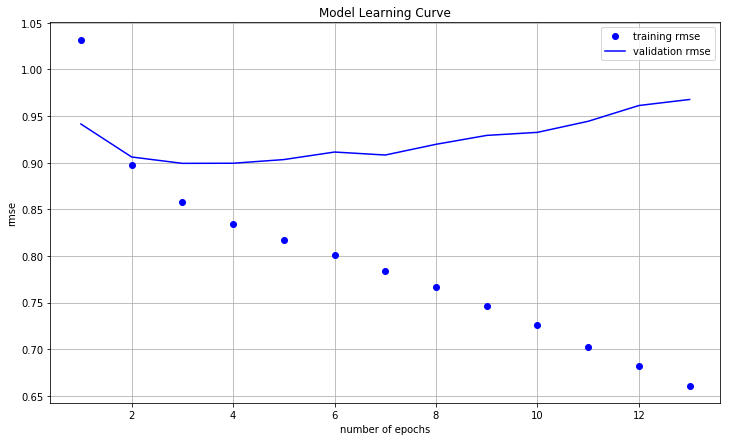

In [29]:
plot_learning_curve(history, 'rmse')

### Neural Matrix Factorization (NeuMF) model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [37]:
# load best model
NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model = load_trained_model(NeuMF_model, os.path.join(data_path, 'tmp/model.hdf5'))
# make prediction using test data
predictions = NeuMF_model.predict([df_test.userId.values, df_test.movieId.values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.9059
